# Projet numérique III : câble sous-marin

#### Louis Blazejczak, Emmanuel Gardin

## Questions théoriques

#### 1.
La loi forte des grands nombres nous autorise à estimer l'espérance conditionnelle par la moyenne empirique de simulations conditionnelles. 

#### 2.

On considère le vecteur gaussien $Z_{1} = (Z(x_{j1}), Z(x_{j2}), ..., Z(x_{jn}))$ et le vecteur $Z_{2}$ des composantes de $Z$ qui ne sont pas connues. On réordonne $Z$ de manière à ce que les termes de $Z1$ soient les n derniers termes de Z.
On note $C$ la matrice de covariance définie positive de $Z$.
$C$ peut se décomposer en blocs :
\begin{align}
C  = 
\begin{pmatrix} 
C_{Z_{2}} & C_{Z_{2},Z_{1}} \\ C_{Z_{1},Z_{2}} & C_{Z_{1}}
\end{pmatrix}
\end{align}

La loi conditionnelle du vecteur des composantes de  $Z$ correspondant aux points de discrétisation sans observation connaissant les valeurs prises par les composantes aux sites d'observation s'écrit alors :


$f_{Z_{2}|Z_{1} = z_{1}}(z_{2}) = \frac{1}{(2 \pi)^{n/2} \sqrt{det(CS_{Z_{2}})}}exp\left(- \frac{1}{2}\left(z_{2}- \Psi(z_1)\right)^{t}CS_{Z_{2}}^{-1}\left(z_{2}- \Psi(z_1)\right)\right)$

où $CS_{Z_{2}}$ est le complément de Schur du bloc $C_{Z_{2}}$ : $CS_{Z_{2}} = C_{Z_{2}} - C_{Z_{2},Z_{1}}C_{Z_{1}}^{-1}C_{Z_{1},Z_{2}}$ et $\Psi$ est l'espérance conditionnelle du vecteur des sites sans observation $Z_{2}$ sachant $Z_{1}$

#### 3.

Soit $Y = (Y_{1}, ..., Y_{p})$ un vecteur de composantes gaussiennes indépendantes, toutes d'espérance nulle et de variance 1. $Z = m + RY$ où $R$ est une matrice $p \times p$ et $m$ est un vecteur de taille $p$.
Alors $Z$ est gaussien, comme combinaison linéaire de variables gaussiennes, $E(Z) = E(m + RY) = m$ et $V(Z) = E((RY)^{2}) = RI_{p}R^{T} = RR^{T}$. On note $C = RR^{t}$.

La loi $f_{Z}$ de $Z$ est alors :

\begin{equation}
f_{Z}(z) = \frac{1}{(2 \pi)^{p/2} \sqrt{det(C)}}exp(- \frac{1}{2}(z-m)^{t}C^{-1}(x-m))
\end{equation}

#### 4.

On souhaite simuler un vecteur gaussien $Z = (Z(x_{0}), ..., Z(x_{p}))$ à valeurs dans ${\rm I\!R}^p$, d'espérance $m$ et de matrice de covariance $C$ définie positive données. D'après la question précédente, on peut simuler un vecteur gaussien quelconque à partir d'un vecteur gaussien $Y$ de composantes indépendantes, d'espérances nulles et de variance 1 si on peut trouver une matrice $R$ telle que $C = R \times R^{T}$, car dans ce cas $Z$ a la même loi que $m + R \times Y$. 

Or, $C$ étant symétrique définie positive, il existe une matrice $R$ vérifiant cela (en effet, le théorème spectral permet de diagonaliser $C = P \Delta P^{T}$ en une matrice diagonale $\Delta$ à coefficients diagonaux strictement positifs, on pose alors $R = P \times \sqrt{\Delta}$ où $\sqrt{\Delta}$ est la matrice diagonale dont les coefficients sont les racines carrées des coefficients de $\Delta$). Il est donc possible de simuler $Z$ à partir de la simulation de $Y$.

L'algorithme de Cholesky permet de trouver une telle matrice $R$ qui est de plus triangulaire inférieure et qu'on appelle alors $L$ (pour Lower triangular matrix). Cet algorithme a l'avantage de ne pas avoir à connaître les valeurs propres de $C$.

### Algorithme de Cholesky :

Il s'agit d'un algorithme récursif qui débute avec $i = 1$ et $C^{(1)} = C$

A l'étape $i$, la matrice $C^{(i)}$ est de la forme suivante :
$C^{(i)}=
\begin{pmatrix}
\mathbf{I}_{i-1} & 0              & 0 \\
0                & a_{i,i}        & \mathbf{b}_{i}^{T} \\
0                & \mathbf{b}_{i} & \mathbf{B}^{(i)}
\end{pmatrix},
$
où $I_{i-1}$ représente la matrice identité de taille $i - 1$.

La matrice $L_{i}$ est définie par :

$L_{i}=
\begin{pmatrix}
I_{i-1} & 0                                  & 0 \\
0                & \sqrt{a_{i,i}}           & 0 \\
0                & \frac{1}{\sqrt{a_{i,i}}} \mathbf{b}_{i} & \mathbf{I}_{n-i}
\end{pmatrix},
$


donc $C^{(i)}$ s'écrit : 


$C^{(i)} = L_{i} C^{(i+1)} L_{i}^{T}$


où


$C^{(i+1)}=
\begin{pmatrix}
\mathbf{I}_{i-1} & 0 & 0 \\
0                & 1 & 0 \\
0                & 0 & \mathbf{B}^{(i)} - \frac{1}{a_{i,i}} \mathbf{b}_{i} \mathbf{b}_{i}^{T}
\end{pmatrix}.$


Après $p$ pas, nous obtenons $C^{p+1} = I_{p}$. La matrice $L$ cherchée est donc :

\begin{equation}
L = L_{1}  L_{2}  ...  L_{p}
\end{equation}


## Implémentation

In [1]:
# Chargement des dépendances

import numpy as np
import math
import matplotlib.pyplot as plt

# Discrétisation

A = 0
B = 500
N = 101
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta

#Paramètres du modèle

mu = -5
a = 50
sigma2 = 12

# Données

observation_indexes = [0, 20, 40, 60, 80, 100]
depth = np.array([0, -4, -12.8, -1, -6.5, 0])

# Indices des composantes correspondant aux observations et aux composantes non observées

unknown_indexes = list(set(discretization_indexes)-set(observation_indexes))

In [2]:
#1
def cov(distance, a, sigma2):
    covariance = np.zeros((101, 101))
    for i in range(0, len(covariance)):
        for j in range(0, len(covariance[0])):
            covariance[i][j] = sigma2*math.exp(-abs(distance[i][j])/a)
    return covariance

In [3]:
#2
distance = np.zeros((101, 101))
for i in range(0, 101):
    for j in range(0, 101):
        distance[i][j] = abs((i-j)*Delta)

In [4]:
#3
C = cov(distance, a, sigma2)
print(C)

[[1.20000000e+01 1.08580490e+01 9.82476904e+00 ... 6.65419193e-04
  6.02096185e-04 5.44799157e-04]
 [1.08580490e+01 1.20000000e+01 1.08580490e+01 ... 7.35401941e-04
  6.65419193e-04 6.02096185e-04]
 [9.82476904e+00 1.08580490e+01 1.20000000e+01 ... 8.12744838e-04
  7.35401941e-04 6.65419193e-04]
 ...
 [6.65419193e-04 7.35401941e-04 8.12744838e-04 ... 1.20000000e+01
  1.08580490e+01 9.82476904e+00]
 [6.02096185e-04 6.65419193e-04 7.35401941e-04 ... 1.08580490e+01
  1.20000000e+01 1.08580490e+01]
 [5.44799157e-04 6.02096185e-04 6.65419193e-04 ... 9.82476904e+00
  1.08580490e+01 1.20000000e+01]]


In [5]:
#4
C_Z1, distanceZ1 = np.zeros((len(observation_indexes),len(observation_indexes))), np.zeros((len(observation_indexes),len(observation_indexes)))
C_Z2, distanceZ2 = np.zeros((len(unknown_indexes),len(unknown_indexes))), np.zeros((len(unknown_indexes),len(unknown_indexes)))
C_Z1_Z2, distanceZ1_Z2 = np.zeros((len(observation_indexes),len(unknown_indexes))), np.zeros((len(observation_indexes),len(unknown_indexes)))

for i in range(len(observation_indexes)):
    for j in range(len(observation_indexes)):
        C_Z1[i][j] = C[observation_indexes[i]][observation_indexes[j]]

for i in range(len(observation_indexes)):
    for j in range(len(unknown_indexes)):
        C_Z1_Z2[i][j] = C[observation_indexes[i]][unknown_indexes[j]]
        
for i in range(len(unknown_indexes)):
    for j in range(len(unknown_indexes)):
        C_Z2[i][j] = C[unknown_indexes[i]][unknown_indexes[j]]



In [6]:
mZ1 = [mu for i in range(len(observation_indexes))]
mZ2 = [mu for i  in range(len(unknown_indexes))]
Z1 = depth
C_Z2_Z1 = C_Z1_Z2.T
Esp_Z2sachantZ1 = mZ2 + (np.dot(C_Z2_Z1,np.linalg.inv(C_Z1)).dot(Z1-mZ1))

Esp_Z_Z1 = {}
index_Z1 = 0
index_Z2 = 0
for i in range(101):
    if i in observation_indexes:
        Esp_Z_Z1[f"{i}"] = depth[index_Z1]
        index_Z1 += 1
    else:
        Esp_Z_Z1[f"{i}"] = Esp_Z2sachantZ1[index_Z2]
        index_Z2 += 1
        
for index in Esp_Z_Z1:
    print(f"{index} :", Esp_Z_Z1[index])

0 : 0.0
1 : -0.4668833484492607
2 : -0.8883977418166769
3 : -1.268761837826951
4 : -1.6117824481977427
5 : -1.9208926384908498
6 : -2.199186087386249
7 : -2.449448049258145
8 : -2.6741832299369017
9 : -2.875640854646853
10 : -3.0558371790083436
11 : -3.21657566840166
12 : -3.359465047654721
13 : -3.4859354017018713
14 : -3.5972524883545685
15 : -3.6945304064309976
16 : -3.778742746031505
17 : -3.8507323325555567
18 : -3.9112196619816215
19 : -3.96081011183309
20 : -4.0
21 : -4.314320932784455
22 : -4.621779358999524
23 : -4.925452425915113
24 : -5.228379395652954
25 : -5.533592063143457
26 : -5.844145099348386
27 : -6.163146623434558
28 : -6.493789309875146
29 : -6.839382341808889
30 : -7.20338453045721
31 : -7.589438932069464
32 : -8.001409308854349
33 : -8.443418798810757
34 : -8.91989118147869
35 : -9.435595152611782
36 : -9.995692050887232
37 : -10.605787514318045
38 : -11.271987583362405
39 : -12.000959812228881
40 : -12.8
41 : -11.918105713568405
42 : -11.105450154373834
43 : -10

#### 6

La matrice de covariance conditionnelle cherchée est : 
\begin{equation}
C_{Z_{2} | Z_{1}} = C_{Z_{2}} - C_{Z_{2}, Z_{1}} \times C_{Z_{1}}^{-1} \times C_{Z_{1}, Z_{2}}
\end{equation}

D'où l'implémentation suivante.

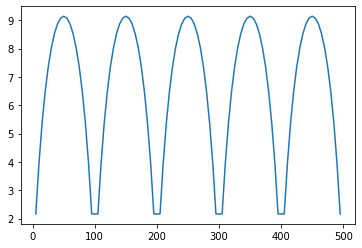

In [7]:
def mat_cov_condi():
    M = C_Z2 - ( (C_Z2_Z1.dot(np.linalg.inv(C_Z1))).dot(C_Z1_Z2) )
    return M

C_Z2sachantZ1 = mat_cov_condi()

position = [i*Delta for i in unknown_indexes]
variance = [C_Z2sachantZ1[i][i] for i in range(95)]

plt.plot(position, variance)

Comme ici, $\Delta = 5$ (m), on obtient logiquement une variance nulle aux points d'observation situés tous les 100m. De la même façon, il paraît logique que la variance augmente lorsqu'on s'éloigne de ces points puisque la position est moins connue loin des sites d'observation.

### 7

## Méthode de Box-Muller

Pour simuler un vecteur gaussien $(Y_{1}, Y_{2})$ de composantes indépendantes, il suffit de considérer deux variables aléatoires uniformes indépendantes $U_{1}$ et $U_{2}$, alors :
\begin{equation}
X_{1} = \sqrt{-2 ln \left(U_{1}\right)} cos \left(2\pi U_{2}\right) \\
X_{2} = \sqrt{-2 ln \left(U_{1}\right)} sin \left(2\pi U_{2}\right)
\end{equation}
sont deux variables aléatoires gaussiennes, indépendantes, d'espérance nulle et d'écart-type 1.

On peut donc simuler autant de paires de composantes gaussiennes indépendantes que l'on veut, ici on veut simuler 95 composantes gaussiennes indépendantes, on va donc simuler 48 paires et enlever une composante à la fin. 

In [8]:
def simul_Y():
    Y = []
    for i in range(48):
        U1 = np.random.random()
        U2 = np.random.random()
        
        X1 = np.sqrt(-2 * np.log(U1))*np.cos(2*np.pi*U2)
        X2 = np.sqrt(-2 * np.log(U1))*np.sin(2*np.pi*U2)
        
        Y.append(X1)
        Y.append(X2)
        
    Y.pop()
    return Y
        

In [9]:
def cholesky(A):
    L = [[0.0] * len(A) for _ in range(len(A))]
    for i, (Ai, Li) in enumerate(zip(A, L)):
        for j, Lj in enumerate(L[:i+1]):
            s = sum(Li[k] * Lj[k] for k in range(j))
            Li[j] = math.sqrt(Ai[i] - s) if (i == j) else \
                      (1.0 / Lj[j] * (Ai[j] - s))
    return L



In [10]:
def nsimul(A, n = 1):
    L1 = cholesky(A)
    L = np.array([np.array(Li) for Li in L1])
    m = Esp_Z2sachantZ1
    
    Liste_res = []
    
    for i in range(n):
        Y = simul_Y()
        res = np.add(m, L.dot(Y))
        for i in range(6):
            res = np.insert(res, observation_indexes[i], depth[i])
        Liste_res.append(res)
        
    return Liste_res

l = nsimul(C_Z2sachantZ1, 20)
print(l)
        

[array([  0.        ,  -0.92095383,   0.37433255,   1.17200057,
        -0.98491062,   1.01039286,  -0.85911331,  -0.63160539,
        -2.04468752,  -2.14990709,  -0.85292447,   2.06691455,
        -0.8892941 ,  -0.9044342 ,  -2.02168996,  -3.06309632,
        -2.73379517,  -3.20719468,  -4.78810216,  -3.4849631 ,
        -4.        ,  -2.73183015,  -4.73363124,  -3.06861952,
        -4.04238096,  -2.80666831,  -3.36937449,  -3.19602768,
        -4.66619051,  -6.90946959,  -8.28356602,  -7.6207951 ,
        -9.90066551,  -9.03010843,  -6.85969613,  -6.42300901,
        -6.12172088,  -9.94585522,  -9.85007495, -11.0253802 ,
       -12.8       , -11.66571906, -11.41978668,  -8.7999952 ,
        -7.50245196,  -7.63814485,  -6.31015861,  -5.96332026,
        -6.0821462 ,  -4.86022809,  -4.74350282,  -5.31217591,
        -2.78573182,  -3.3772281 ,  -0.36581761,  -3.17595244,
        -4.13873509,  -3.12856389,  -3.89280108,  -2.72370266,
        -1.        ,  -0.82752965,  -2.43641114,  -2.8

In [11]:
def longueur(Z, Delta):
    length = 0
    for i in range(len(Z)-1):
        length += math.sqrt(Delta**2+(Z[i+1]-Z[i])**2)
    return length

In [12]:
def compare(nbsimul, Esp = Esp_Z2sachantZ1):
    for i in range(6):
        Esp = np.insert(Esp, observation_indexes[i], depth[i])
        
    LengthEsp = longueur(Esp, Delta)
    l = nsimul(C_Z2sachantZ1, nbsimul)
    EcartType = 0
    Length = 0
    for simul in l:
        EcartType += (longueur(simul, Delta)-LengthEsp)**2
        Length +=  longueur(simul, Delta)
    Length = Length/nbsimul
    EcartType = np.sqrt(EcartType/nbsimul)
    EcartRelatif = (Length - LengthEsp)/LengthEsp
    print("Longueur simulation = ", Length)
    print("Longueur espérance = ", LengthEsp)
    print("Ecart type = ", EcartType)
    print("Ecart relatif = ", EcartRelatif)

compare(100)

Longueur simulation =  522.5217857300138
Longueur espérance =  501.6468416918411
Ecart type =  21.10762365667624
Ecart relatif =  0.04161282859425651


On retrouve même pour des grands nombres de simulations (voir plus bas) un écart constant d'environ 20m entre la longueur obtenue par la moyenne des longueurs simulées et la longueur obtenue par calcul de l'espérance conditionnelle. Cela s'explique par le fait que du fait de la nature aléatoire de la simulation, le câble a tendance à rapidement monter puis descendre ce qui augmente "artificiellement" sa longueur, contrairement à la longueur obtenue par calcul de l'espérance conditionnelle qui modélise un câble plus lisse.

Graphiquement, il semblerait que la moyenne des longueurs converge vers une valeur proche de M_100 = 522.997


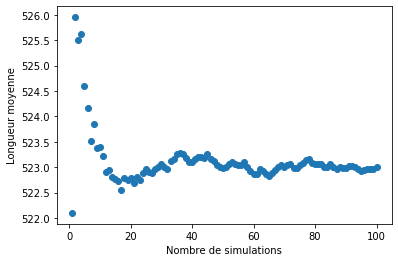

In [13]:
l = nsimul(C_Z2sachantZ1, 100)
Longueurs = []
for simul in l:
	Longueurs.append(longueur(simul, Delta))
    
def Moyenne(Long, ax = None) :
    NB = len(Long)
    
    NSimulations = [k for k in range(1, NB+1)]
    Moyennes = [np.average(Long[:i]) for i in range(1, NB+1)]
    if ax == None :
        ax = plt.gca()
    ax.set_xlabel("Nombre de simulations")
    ax.set_ylabel("Longueur moyenne")
    ax.scatter(NSimulations, Moyennes)
    print(f"Graphiquement, il semblerait que la moyenne des longueurs converge vers une valeur proche de M_{NB} = {np.round(Moyennes[-1], 3)}m")
    
Moyenne(Longueurs)

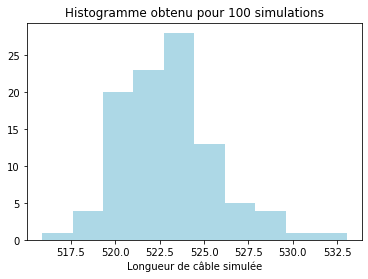

In [14]:
def histogramme(L, ax = None) :
    N = len(L)
    num_bins = min(int(np.sqrt(N)), 100)
    if ax == None :
        ax = plt.gca()
    n, bins, patches = ax.hist(L, num_bins, facecolor='lightblue')
    ax.set_xlabel("Longueur de câble simulée")
    ax.set_title(f"Histogramme obtenu pour {N} simulations")

histogramme(Longueurs)

#### 12

On propose les deux implémentations suivantes : l'une par estimation avec l'allure de l'approximation gaussienne de la longueur, l'autre par le calcul à l'aide d'une formule qui permet d'estimer la moyenne de la longueur du câble.

[518.0266545649262, 528.0273088346016]


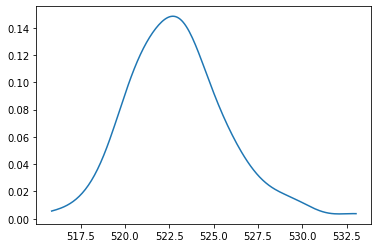

In [27]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace


def ApproxGaussienne(L):

    kde = gaussian_kde(L)
    interv_definition = linspace(min(L), max(L), 200)
    y = kde(interv_definition)
    fig = plt.figure()
    plt.plot( interv_definition, y )
    return interv_definition, y

def IntervConfiance95_1(L):
    x, y = ApproxGaussienne(L)
    I_conf = []
    to_remove = []
    for i in range(len(y)):
        if y[i] <= 0.025:
            to_remove.append(i)
            
    in_interval = [x[i] for i in range(len(y)) if not (i in to_remove)]
    
    I_conf.append(min(in_interval))
    I_conf.append(max(in_interval))

    return I_conf

I1 = IntervConfiance95_1(Longueurs)
print(I1)

In [45]:
def mean_and_var(L):
    m = np.mean(L)
    L_ecart = np.add(L, -m)
    L_ecart = np.square(L_ecart)
    var = np.mean(L_ecart)

    return m, var

def IntervConfiance95_2(L):
    m, V = mean_and_var(L)
    n = len(L)
    sigma = np.sqrt(V)
    I_conf = [m - 2*(sigma/np.sqrt(n)), m + 2*(sigma/np.sqrt(n))]

    return I_conf

I2 = IntervConfiance95_2(Longueurs)
print(I2)

[522.4218384730697, 522.4583915437253]


Dans les deux cas, on vérifie effectivement que les simulations précédentes basées sur une approximation en loi normale sont quasiment toujours comprises dans ces intervalles (même si leur nature est différente)

In [32]:
from scipy.integrate import quad

def proba_depasse(L, lmax = 525):
    m, V = np.mean(L), var(L)
    sigma = np.sqrt(V)

    def f(l):
        return ( 1/(sigma * np.sqrt(2*np.pi)) ) * np.exp(-0.5 * ( (l - m)/sigma )**2 )
    
    P = quad(f, lmax, np.inf)[0]

    return P

P = proba_depasse(Longueurs)
print(P)

0.23376902707836525


#### 14

Longueur simulation =  522.4943363739275
Longueur espérance =  501.6468416918411
Ecart type =  21.04424873586708
Ecart relatif =  0.04155811010745463
Graphiquement, il semblerait que la moyenne des longueurs converge vers une valeur proche de M_1000 = 522.591


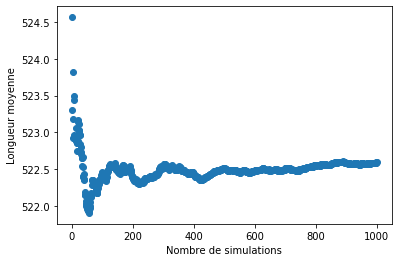

In [46]:
n = 1000

compare(n)

l = nsimul(C_Z2sachantZ1, n)

Longueurs = []
for simul in l:
	Longueurs.append(longueur(simul, Delta))
    
Moyenne(Longueurs)

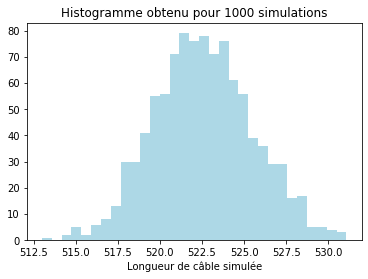

In [47]:
histogramme(Longueurs)

[517.2688074831393, 528.3587389257779]
[522.4057565566624, 522.7772057133878]


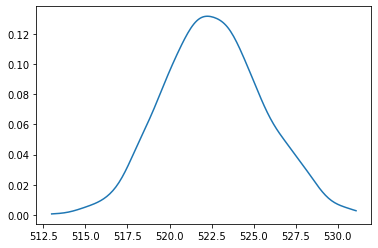

In [48]:
I1 = IntervConfiance95_1(Longueurs)
print(I1)

I2 = IntervConfiance95_2(Longueurs)
print(I2)

In [49]:
P = proba_depasse(Longueurs)
print(P)

0.20605594777213193


Longueur simulation =  522.4204961755916
Longueur espérance =  501.6468416918411
Ecart type =  20.977671049208848
Ecart relatif =  0.0414109145264222
Graphiquement, il semblerait que la moyenne des longueurs converge vers une valeur proche de M_10000 = 522.421


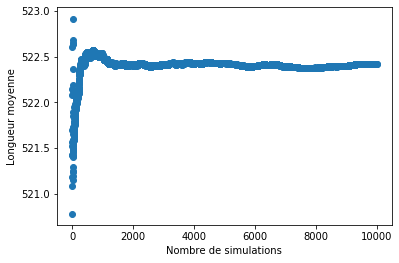

In [50]:
n = 10000

compare(n)

l = nsimul(C_Z2sachantZ1, n)

Longueurs = []
for simul in l:
	Longueurs.append(longueur(simul, Delta))
    
Moyenne(Longueurs)

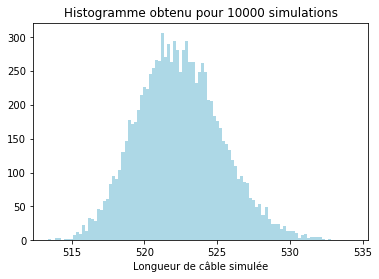

In [51]:
histogramme(Longueurs)

[517.1903804483142, 527.8088892158138]
[522.3630073791347, 522.4795457366182]


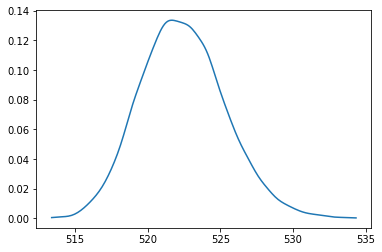

In [52]:
I1 = IntervConfiance95_1(Longueurs)
print(I1)

I2 = IntervConfiance95_2(Longueurs)
print(I2)

In [53]:
P = proba_depasse(Longueurs)
print(P)

0.18804941197758535


Longueur simulation =  522.4460780923695
Longueur espérance =  501.6468416918411
Ecart type =  20.998875483877942
Ecart relatif =  0.04146191039573066
Graphiquement, il semblerait que la moyenne des longueurs converge vers une valeur proche de M_100000 = 522.436


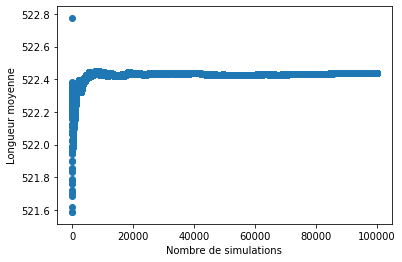

In [54]:
n = 100000

compare(n)

l = nsimul(C_Z2sachantZ1, n)

Longueurs = []
for simul in l:
	Longueurs.append(longueur(simul, Delta))
    
Moyenne(Longueurs)

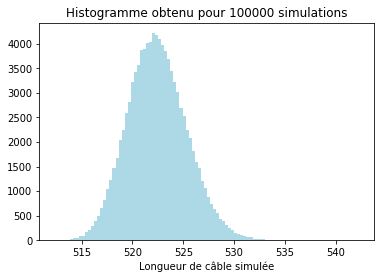

In [55]:
histogramme(Longueurs)

[517.1651492146065, 527.6947130916994]
[522.4180031844758, 522.4545128139239]


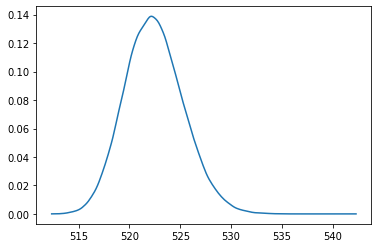

In [56]:
I1 = IntervConfiance95_1(Longueurs)
print(I1)

I2 = IntervConfiance95_2(Longueurs)
print(I2)

In [57]:
P = proba_depasse(Longueurs)
print(P)

0.18720772641831027


## Conclusion

Comme nous pouvons le voir dans cette dernière question, on observe clairement que lorsque le nombre de simulation augmente, on converge vers une loi normale pour les simulations de longueur du câble en vertu du théorème central limite. 

Les approximations en loi normale sont donc naturellement plus précises et appropriées lorsque le nombre de simulations est élevé.

Cependant, la nature aléatoire de ces simulations a tendance à donner une allure de câble "tordu" car les simulations ont tendance à donner pour deux positions successives une valeur haute et une valeur basse, ce qui augmente la longueur du câble. Pour remédier à cela, il faudrait augmenter la résolution de calcul, c'est-à-dire augmenter le paramètre $N$, ce qui impliquera également des temps de calcul augmentés (alors qu'ils sont déjà relativement longs pour des valeurs élevées de nombre de simulations). Malgré ce facteur, nous obtenons une estimation convenable de la longueur du câble en ne connaissant la profondeur qu'en six points et avec une méthode de simulation plutôt basique (pas de prise en compte du fait que la profondeur est toujours négative, faible résolution...)